In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.colors import TwoSlopeNorm
from tqdm import tqdm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
repo_name = "PVRecycling"
repo_url = "https://github.com/pleu/PVRecycling.git"

if os.path.basename(os.getcwd()) == repo_name:
    os.chdir("..")

if os.path.exists(repo_name):
    import shutil
    shutil.rmtree(repo_name)

os.system(f'git clone {repo_url}')
os.chdir(repo_name)


Cloning into 'PVRecycling'...


In [5]:
def build_conversion_matrix(year):
    """Create conversion matrix based on year"""
    if year == 2020:
        # 2020 Constants
        kg_per_wafer = 0.015  # kg/wafer
        cells_per_module = 60
        cell_area_m2 = 244e-4  # 244 cm² → 0.0244 m²
        irradiance = 1000  # W/m² (STC)
        CTM_ratio = 0.98
        median_efficiency = 21.5  # %
    elif year == 2025:
        # 2025 Constants
        kg_per_wafer = 0.016  # kg/wafer
        cells_per_module = 60
        cell_area_m2 = 331e-4  # 331 cm² → 0.0331 m²
        irradiance = 1000  # W/m² (STC)
        CTM_ratio = 0.99
        median_efficiency = 23  # %
    else:
        # Interpolate for years between 2020 and 2025
        factor = (year - 2020) / 5
        kg_per_wafer = 0.015 + factor * (0.016 - 0.015)
        cells_per_module = 60  # constant
        cell_area_m2 = 244e-4 + factor * (331e-4 - 244e-4)
        irradiance = 1000  # constant
        CTM_ratio = 0.98 + factor * (0.99 - 0.98)
        median_efficiency = 21.5 + factor * (23 - 21.5)
    
    # Calculate conversion factors
    wafers_per_kg = 1 / kg_per_wafer
    cells_per_wafer = 1  # Assuming 1 cell per wafer
    modules_per_cell = 1 / cells_per_module
    
    # Calculate Wp per unit
    efficiency_decimal = median_efficiency / 100
    Wp_per_cell = cell_area_m2 * irradiance * efficiency_decimal
    Wp_per_module = Wp_per_cell * cells_per_module * CTM_ratio
    Wp_per_wafer = Wp_per_cell
    Wp_per_kg = Wp_per_wafer * wafers_per_kg
    
    # Create the conversion matrix
    factors = {
        'kg': {'kg': 1, 'wafer': wafers_per_kg, 'cell': wafers_per_kg, 'module': wafers_per_kg * modules_per_cell, 'Wp': Wp_per_kg},
        'wafer': {'kg': kg_per_wafer, 'wafer': 1, 'cell': 1, 'module': modules_per_cell, 'Wp': Wp_per_wafer},
        'cell': {'kg': kg_per_wafer, 'wafer': 1, 'cell': 1, 'module': modules_per_cell, 'Wp': Wp_per_cell},
        'module': {'kg': kg_per_wafer / modules_per_cell, 'wafer': 1 / modules_per_cell, 'cell': 1 / modules_per_cell, 'module': 1, 'Wp': Wp_per_module},
        'Wp': {'kg': 1 / Wp_per_kg, 'wafer': 1 / Wp_per_wafer, 'cell': 1 / Wp_per_cell, 'module': 1 / Wp_per_module, 'Wp': 1}
    }
    
    return pd.DataFrame(factors)

def convert_dataframe_units(df, target_unit, conversion_matrix):
    """Convert costs to target units"""
    converted_df = df.copy()
    
    for idx, row in converted_df.iterrows():
        source_unit = row['Unit']
        conversion_factor = conversion_matrix.at[source_unit, target_unit]
        
        # Convert cost columns
        cost_columns = ['Process Cost', 'Process Cost Min', 'Process Cost Max']
        for col in cost_columns:
            if col in converted_df.columns:
                converted_df.at[idx, col] = row[col] / conversion_factor
    
    return converted_df


In [7]:
def read_production_steps(year):
    """Read production steps with actual data"""
    if year == 2020:
        # 2020 Production step cost data
        production_step_data = {
            'Production Step': [
                'Purchase mg-Si',
                'SoG Poly-Si (exclude mg-Si cost)',
                'Mono Wafer (exclude poly-Si cost)',
                'Mono PERC cell (exclude wafer cost)',
                'Mono PERC module (exclude cell cost)',
                'Recycled mg-Si',
                'Recycled SOG poly-Si',
                'Recycled Mono wafer'
            ],
            'Unit': ['kg', 'kg', 'wafer', 'cell', 'module', 'kg', 'kg', 'cell'],
            'Distribution': ['Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Uniform', 'Uniform', 'Uniform'],
            'Process Cost': [2.5, 7.2, 0.24, 0.22, 39, 1.5, 5.8, 0.245],
            'Process Cost Range': [
                (2, 3),
                (5.8, 8.6),
                (0.19, 0.29),
                (0.17, 0.26),
                (31, 47),
                (0, 3),
                (0, 11.6),
                (0, 0.49)
            ]
        }
    elif year == 2025:
        # 2025 Production step cost data
        production_step_data = {
            'Production Step': [
                'Purchase mg-Si',
                'SoG Poly-Si (exclude mg-Si cost)',
                'Mono Wafer (exclude poly-Si cost)',
                'Mono PERC cell (exclude wafer cost)',
                'Mono PERC module (exclude cell cost)',
                'Recycled mg-Si',
                'Recycled SOG poly-Si',
                'Recycled Mono wafer'
            ],
            'Unit': ['kg', 'kg', 'wafer', 'cell', 'module', 'kg', 'kg', 'cell'],
            'Distribution': ['Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Uniform', 'Uniform', 'Uniform'],
            'Process Cost': [3.97, 9.5, 0.36, 0.32, 49, 2.38, 7.65, 0.3675],
            'Process Cost Range': [
                (3.18, 4.76),
                (7.6, 11.4),
                (0.29, 0.43),
                (0.26, 0.38),
                (39, 59),
                (0, 4.76),
                (0, 15.3),
                (0, 0.735)
            ]
        }
    else:
        # Interpolate for years between 2020 and 2025
        factor = (year - 2020) / 5
        
        # 2020 data
        steps_2020 = [
            'Purchase mg-Si',
            'SoG Poly-Si (exclude mg-Si cost)',
            'Mono Wafer (exclude poly-Si cost)',
            'Mono PERC cell (exclude wafer cost)',
            'Mono PERC module (exclude cell cost)',
            'Recycled mg-Si',
            'Recycled SOG poly-Si',
            'Recycled Mono wafer'
        ]
        
        costs_2020 = [2.5, 7.2, 0.24, 0.22, 39, 1.5, 5.8, 0.245]
        
        min_costs_2020 = [2, 5.8, 0.19, 0.17, 31, 0, 0, 0]
        max_costs_2020 = [3, 8.6, 0.29, 0.26, 47, 3, 11.6, 0.49]
        
        # 2025 data
        costs_2025 = [3.97, 9.5, 0.36, 0.32, 49, 2.38, 7.65, 0.3675]
        
        min_costs_2025 = [3.18, 7.6, 0.29, 0.26, 39, 0, 0, 0]
        max_costs_2025 = [4.76, 11.4, 0.43, 0.38, 59, 4.76, 15.3, 0.735]
        
        # Interpolate costs
        interp_costs = [costs_2020[i] + factor * (costs_2025[i] - costs_2020[i]) for i in range(len(costs_2020))]
        interp_min_costs = [min_costs_2020[i] + factor * (min_costs_2025[i] - min_costs_2020[i]) for i in range(len(min_costs_2020))]
        interp_max_costs = [max_costs_2020[i] + factor * (max_costs_2025[i] - max_costs_2020[i]) for i in range(len(max_costs_2020))]
        
        # Create interpolated data
        production_step_data = {
            'Production Step': steps_2020,
            'Unit': ['kg', 'kg', 'wafer', 'cell', 'module', 'kg', 'kg', 'cell'],
            'Distribution': ['Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Uniform', 'Uniform', 'Uniform'],
            'Process Cost': interp_costs,
            'Process Cost Range': [(interp_min_costs[i], interp_max_costs[i]) for i in range(len(interp_min_costs))]
        }
    
    # Create the DataFrame
    df = pd.DataFrame(production_step_data)
    
    # Split Process Cost Range into separate columns
    df['Process Cost Min'] = df['Process Cost Range'].apply(lambda x: x[0])
    df['Process Cost Max'] = df['Process Cost Range'].apply(lambda x: x[1])
    df.drop('Process Cost Range', axis=1, inplace=True)
    
    return df


In [9]:
def read_efficiency_data(year):
    """Read efficiency data with actual data"""
    if year == 2020:
        # 2020 Efficiency data
        efficiency_data = {
            'Scenario': ['A', 'B', 'C', 'D'],
            'Distribution': ['Normal', 'Uniform', 'Uniform', 'Uniform'],
            'Median Efficiency': [21.5, 21.5, 19, 19],
            'Efficiency Range': [
                (21, 22),
                (21, 22),
                (16.5, 21.5),
                (16.5, 21.5),
            ]
        }
    elif year == 2025:
        # 2025 Efficiency data
        efficiency_data = {
            'Scenario': ['A', 'B', 'C', 'D'],
            'Distribution': ['Normal', 'Uniform', 'Uniform', 'Uniform'],
            'Median Efficiency': [23, 23, 20.5, 20.5],
            'Efficiency Range': [
                (22.5, 23.5),
                (21, 22),
                (18, 23),
                (18, 23),
            ]
        }
    else:
        # Interpolate for years between 2020 and 2025
        factor = (year - 2020) / 5
        
        # 2020 data
        eff_2020 = [21.5, 21.5, 19, 19]
        min_eff_2020 = [21, 21, 16.5, 16.5]
        max_eff_2020 = [22, 22, 21.5, 21.5]
        
        # 2025 data
        eff_2025 = [23, 23, 20.5, 20.5]
        min_eff_2025 = [22.5, 21, 18, 18]
        max_eff_2025 = [23.5, 22, 23, 23]
        
        # Interpolate values
        interp_eff = [eff_2020[i] + factor * (eff_2025[i] - eff_2020[i]) for i in range(len(eff_2020))]
        interp_min_eff = [min_eff_2020[i] + factor * (min_eff_2025[i] - min_eff_2020[i]) for i in range(len(min_eff_2020))]
        interp_max_eff = [max_eff_2020[i] + factor * (max_eff_2025[i] - max_eff_2020[i]) for i in range(len(max_eff_2020))]
        
        # Create interpolated data
        efficiency_data = {
            'Scenario': ['A', 'B', 'C', 'D'],
            'Distribution': ['Normal', 'Uniform', 'Uniform', 'Uniform'],
            'Median Efficiency': interp_eff,
            'Efficiency Range': [(interp_min_eff[i], interp_max_eff[i]) for i in range(len(interp_min_eff))]
        }
    
    # Create the DataFrame
    df = pd.DataFrame(efficiency_data)
    
    # Split Efficiency Range into separate columns
    df['Min Efficiency'] = df['Efficiency Range'].apply(lambda x: x[0])
    df['Max Efficiency'] = df['Efficiency Range'].apply(lambda x: x[1])
    df.drop('Efficiency Range', axis=1, inplace=True)
    
    return df

In [11]:
scenario_steps = {
    'A': [
        'Purchase mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'B': [
        'Recycled mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'C': [
        'Recycled SoG poly-Si',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'D': [
        'Recycled mono wafer',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ]
}

# Production type lists
polysilicon_steps = [ 
    'Purchase mg-Si', 'SoG Poly-Si (exclude mg-Si cost)', 
    'Recycled mg-Si', 'Recycled SOG poly-Si' 
]
wafer_steps = polysilicon_steps + [ 
    'Mono Wafer (exclude poly-Si cost)', 'Recycled Mono wafer' 
]
cell_steps = wafer_steps + [ 
    'Mono PERC cell (exclude wafer cost)', 'Recycled cell' 
]


In [13]:
def filter_rows_by_production_type(df, production_type, scenario):
    df_scenario = df[df['Scenario'] == scenario]

    if production_type == 'SoG Si':
        return df_scenario[df_scenario['Production Step'].isin(polysilicon_steps)]
    elif production_type == 'wafer':
        return df_scenario[df_scenario['Production Step'].isin(wafer_steps)]
    elif production_type == 'cell':
        return df_scenario[df_scenario['Production Step'].isin(cell_steps)]
    elif production_type == 'module':
        return df_scenario
    else:
        raise ValueError(f"Unknown production_type: {production_type}")

def generate_total_cost(df, n_samples):
    samples = {}
    for idx, row in df.iterrows():
        step = row['Production Step']
        median = row['Process Cost']
        dist_type = row['Distribution']
        low = row['Process Cost Min']
        high = row['Process Cost Max']

        if dist_type.lower() == 'log-normal':
            mu = np.log(median)
            sigma = (np.log(high) - np.log(low)) / 4
            samples[step] = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
        elif dist_type.lower() == 'uniform':
            samples[step] = np.random.uniform(low=low, high=high, size=n_samples)
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")
    
    total_cost = np.sum(np.array(list(samples.values())), axis=0)
    return total_cost

def get_efficiency_distribution(efficiency_df, scenario, n_samples):
    row = efficiency_df[efficiency_df['Scenario'] == scenario]
    distribution = row['Distribution'].values[0]
    median = row['Median Efficiency'].values[0]
    low = row['Min Efficiency'].values[0]
    high = row['Max Efficiency'].values[0]
    
    if distribution.lower() == 'uniform':
        samples = np.random.uniform(low, high, n_samples)
    elif distribution.lower() == 'normal':
        std_dev = (high - low) / 4
        samples = np.random.normal(loc=median, scale=std_dev, size=n_samples)
    else:
        samples = np.full(n_samples, median)
    
    return samples

def generate_costs_by_scenario(df, efficiency_df, production_type, target_unit, conversion_matrix):
    scenarios = df['Scenario'].unique().tolist()
    cost_results = {}
    n_samples = 5000
    
    for scenario in scenarios:
        filtered_df = filter_rows_by_production_type(df, production_type, scenario)
        filtered_df = convert_dataframe_units(filtered_df, target_unit, conversion_matrix)
        total_cost = generate_total_cost(filtered_df, n_samples)

        if target_unit == 'Wp':
            efficiencies = get_efficiency_distribution(efficiency_df, scenario, n_samples)
            reference_efficiency = efficiency_df[efficiency_df['Scenario'] == 'A']['Median Efficiency'].values[0]
            efficiency_ratio = efficiencies / reference_efficiency
            total_cost = total_cost / efficiency_ratio

        cost_results[scenario] = total_cost
    
    return cost_results


In [15]:
def prepare_scenario_data(year):
    conversion_matrix = build_conversion_matrix(year)
    production_step_df = read_production_steps(year)
    efficiency_df = read_efficiency_data(year)
    
    # Prepare scenario data
    scenario_step_map = []
    for scenario, steps in scenario_steps.items():
        for step in steps:
            # Find matching production step
            matches = production_step_df[production_step_df['Production Step'].str.lower() == step.lower()]
            if not matches.empty:
                row = matches.iloc[0].to_dict()
                row['Scenario'] = scenario
                scenario_step_map.append(row)
    
    df = pd.DataFrame(scenario_step_map)
    cols = ['Scenario'] + [col for col in df.columns if col != 'Scenario']
    return df[cols], efficiency_df, conversion_matrix

def track_parameter_changes(years=range(2020, 2026)):
    """Track how parameters change over years"""
    param_changes = []
    
    for year in years:
        production_step_df = read_production_steps(year)
        efficiency_df = read_efficiency_data(year)
        
        # Track process cost changes
        for step in production_step_df['Production Step'].unique():
            step_data = production_step_df[production_step_df['Production Step'] == step].iloc[0]
            param_changes.append({
                'Year': year,
                'Parameter': 'Process Cost',
                'Production Step': step,
                'Value': step_data['Process Cost']
            })
        
        # Track efficiency changes
        for scenario in efficiency_df['Scenario']:
            eff_data = efficiency_df[efficiency_df['Scenario'] == scenario].iloc[0]
            param_changes.append({
                'Year': year,
                'Parameter': 'Efficiency',
                'Scenario': scenario,
                'Value': eff_data['Median Efficiency']
            })
    
    return pd.DataFrame(param_changes)

def calculate_parameter_impact(base_year=2020, n_samples=5000):
    """Quantify impact of each parameter on costs"""
    # Load base data
    base_df, base_efficiency_df, base_conversion_matrix = prepare_scenario_data(base_year)
    
    # Get base costs
    base_costs = generate_costs_by_scenario(
        base_df, base_efficiency_df, 'module', 'Wp', base_conversion_matrix
    )
    base_median = {scenario: np.median(costs) for scenario, costs in base_costs.items()}
    
    # Test impact of each parameter
    impact_results = []
    scenarios = ['A', 'B', 'C', 'D']
    
    # 1. Impact of process costs
    for step in base_df['Production Step'].unique():
        for scenario in scenarios:
            # Create modified df
            mod_df = base_df.copy()
            mask = (mod_df['Production Step'] == step) & (mod_df['Scenario'] == scenario)
            
            # Apply 10% reduction to this step
            reduction = 0.9
            mod_df.loc[mask, 'Process Cost'] *= reduction
            mod_df.loc[mask, 'Process Cost Min'] *= reduction
            mod_df.loc[mask, 'Process Cost Max'] *= reduction
            
            # Calculate new costs
            mod_costs = generate_costs_by_scenario(
                mod_df, base_efficiency_df, 'module', 'Wp', base_conversion_matrix
            )
            mod_median = np.median(mod_costs[scenario])
            
            # Calculate impact
            impact = (mod_median - base_median[scenario]) / base_median[scenario] * 100
            impact_results.append({
                'Parameter': 'Process Cost',
                'Production Step': step,
                'Scenario': scenario,
                'Impact (%)': impact
            })
    
    # 2. Impact of efficiencies
    for scenario in scenarios:
        # Create modified efficiency df
        mod_eff = base_efficiency_df.copy()
        mask = mod_eff['Scenario'] == scenario
        
        # Apply 5% improvement to this scenario
        improvement = 1.05
        mod_eff.loc[mask, 'Median Efficiency'] *= improvement
        mod_eff.loc[mask, 'Min Efficiency'] *= improvement
        mod_eff.loc[mask, 'Max Efficiency'] *= improvement
        
        # Calculate new costs
        mod_costs = generate_costs_by_scenario(
            base_df, mod_eff, 'module', 'Wp', base_conversion_matrix
        )
        mod_median = np.median(mod_costs[scenario])
        
        # Calculate impact
        impact = (mod_median - base_median[scenario]) / base_median[scenario] * 100
        impact_results.append({
            'Parameter': 'Efficiency',
            'Scenario': scenario,
            'Impact (%)': impact
        })
    
    return pd.DataFrame(impact_results)


In [17]:
def plot_parameter_trends(param_df):
    """Plot how parameters change over years"""
    plt.figure(figsize=(12, 8))
    
    # Process cost trends
    plt.subplot(2, 1, 1)
    for step in param_df[param_df['Parameter'] == 'Process Cost']['Production Step'].unique():
        step_data = param_df[(param_df['Parameter'] == 'Process Cost') & 
                            (param_df['Production Step'] == step)]
        plt.plot(step_data['Year'], step_data['Value'], 'o-', label=step)
    
    plt.title('Process Cost Trends (2020-2025)')
    plt.xlabel('Year')
    plt.ylabel('Cost ($)')
    plt.legend()
    plt.grid(True)
    
    # Efficiency trends
    plt.subplot(2, 1, 2)
    for scenario in param_df[param_df['Parameter'] == 'Efficiency']['Scenario'].unique():
        eff_data = param_df[(param_df['Parameter'] == 'Efficiency') & 
                          (param_df['Scenario'] == scenario)]
        plt.plot(eff_data['Year'], eff_data['Value'], 'o-', label=f'Scenario {scenario}')
    
    plt.title('Efficiency Trends (2020-2025)')
    plt.xlabel('Year')
    plt.ylabel('Efficiency')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_parameter_impact(impact_df):
    """Visualize the impact of each parameter on costs"""
    plt.figure(figsize=(14, 8))
    
    # Process cost impact
    plt.subplot(1, 2, 1)
    process_impact = impact_df[impact_df['Parameter'] == 'Process Cost']
    sns.barplot(x='Impact (%)', y='Production Step', hue='Scenario', data=process_impact)
    plt.title('Impact of Process Cost Changes on Module Cost')
    plt.xlabel('Cost Change (%)')
    plt.ylabel('Production Step')
    
    # Efficiency impact
    plt.subplot(1, 2, 2)
    eff_impact = impact_df[impact_df['Parameter'] == 'Efficiency']
    sns.barplot(x='Impact (%)', y='Scenario', data=eff_impact)
    plt.title('Impact of Efficiency Changes on Module Cost')
    plt.xlabel('Cost Change (%)')
    plt.ylabel('Scenario')
    
    plt.tight_layout()
    plt.show()

def plot_most_influential_parameters(impact_df):
    """Identify and plot the most influential parameters"""
    # Calculate absolute impact
    impact_df['Abs Impact'] = abs(impact_df['Impact (%)'])
    
    # Get top 10 most impactful parameters
    top_params = impact_df.nlargest(10, 'Abs Impact')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Abs Impact', y='Parameter', hue='Scenario', 
               data=top_params, orient='h')
    plt.title('Top 10 Most Influential Parameters')
    plt.xlabel('Absolute Impact on Cost (%)')
    plt.ylabel('Parameter')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()


TRACKING PARAMETER CHANGES (2020-2025)

Parameter Trends Summary:
   Year     Parameter                       Production Step  Value Scenario
0  2020  Process Cost                        Purchase mg-Si   2.50      NaN
1  2020  Process Cost      SoG Poly-Si (exclude mg-Si cost)   7.20      NaN
2  2020  Process Cost     Mono Wafer (exclude poly-Si cost)   0.24      NaN
3  2020  Process Cost   Mono PERC cell (exclude wafer cost)   0.22      NaN
4  2020  Process Cost  Mono PERC module (exclude cell cost)  39.00      NaN

Plotting parameter trends...


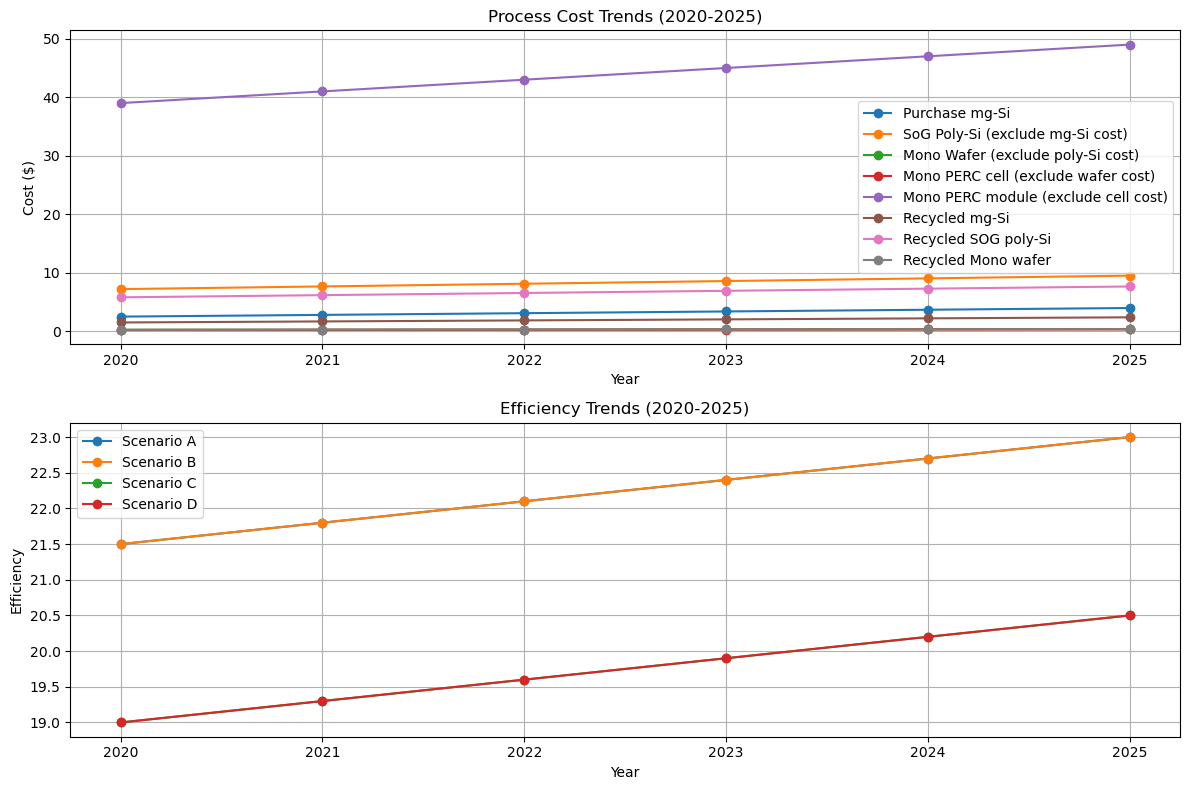


CALCULATING PARAMETER IMPACT

Parameter Impact Summary:
       Parameter                      Production Step Scenario  Impact (%)
22  Process Cost                       Recycled mg-Si        C    0.940876
30  Process Cost                  Recycled Mono wafer        C    0.645597
14  Process Cost  Mono PERC cell (exclude wafer cost)        C    0.451248
1   Process Cost                       Purchase mg-Si        B    0.445222
2   Process Cost                       Purchase mg-Si        C    0.315698
25  Process Cost                 Recycled SOG poly-Si        B    0.279406
32    Efficiency                                  NaN        A    0.267382
28  Process Cost                  Recycled Mono wafer        A    0.259847
9   Process Cost    Mono Wafer (exclude poly-Si cost)        B    0.250974
6   Process Cost     SoG Poly-Si (exclude mg-Si cost)        C    0.250716

Plotting parameter impact...


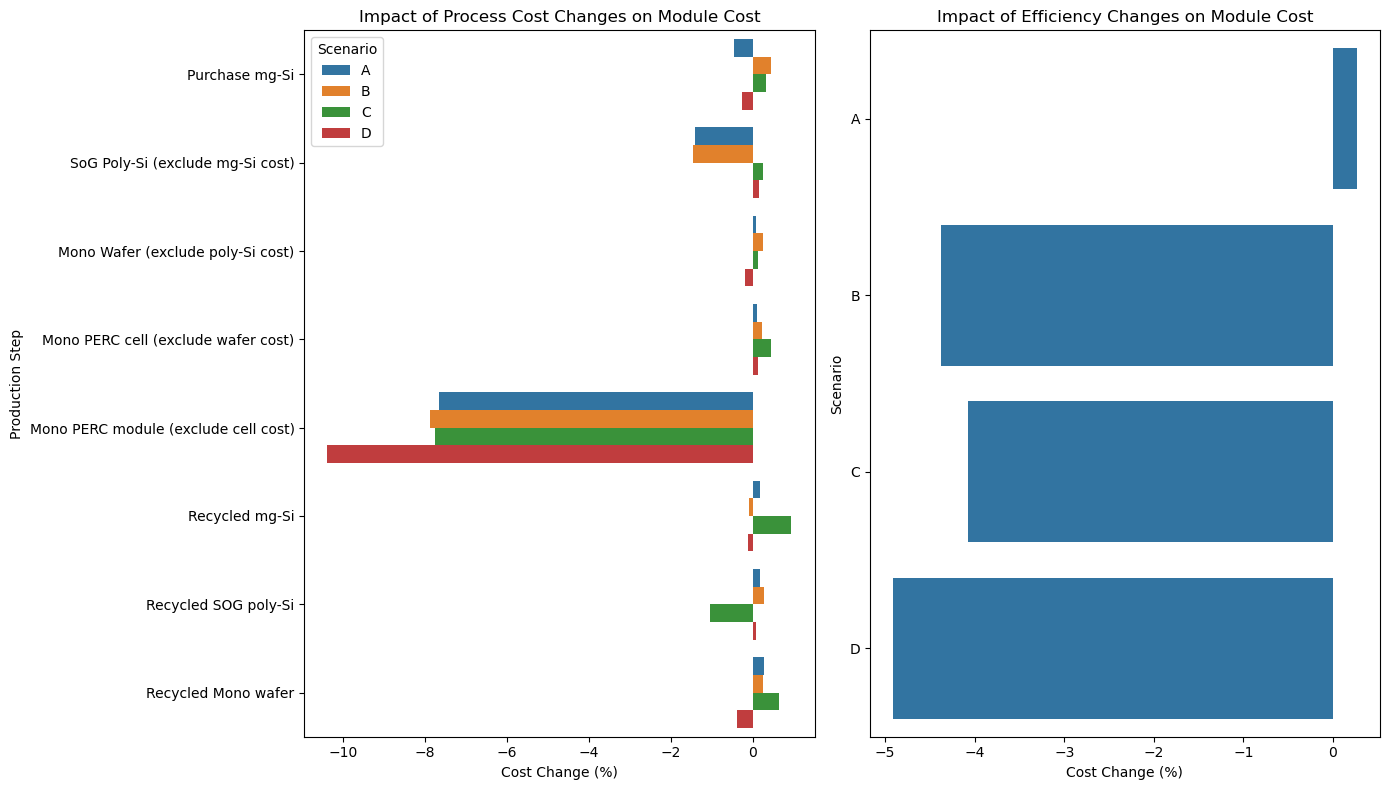


Identifying most influential parameters...


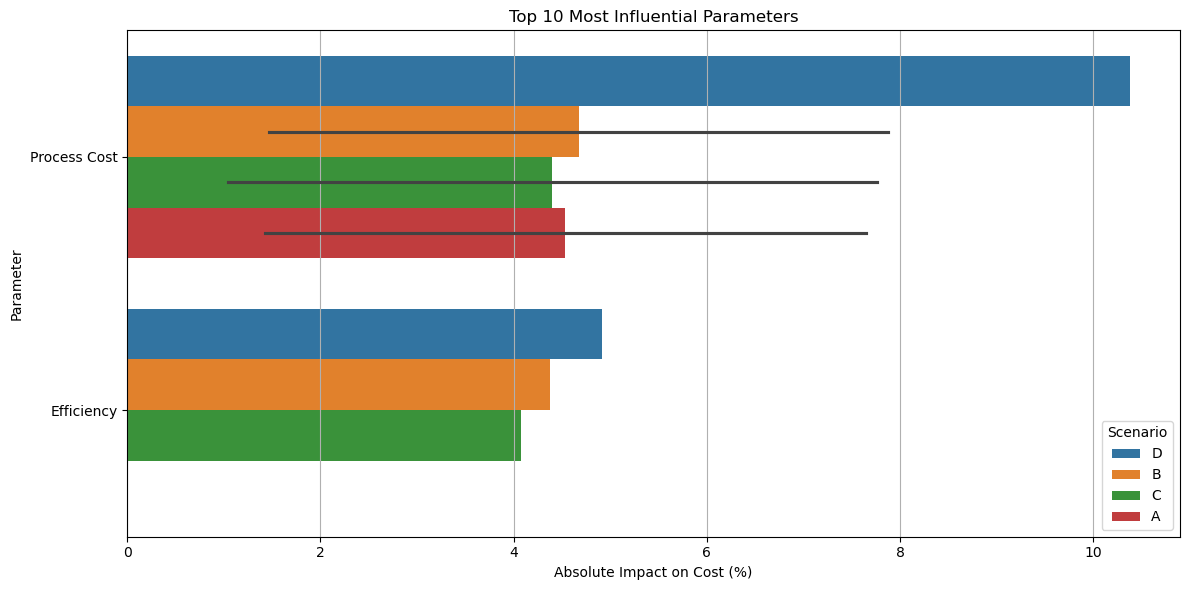


Results saved to CSV files


In [22]:
if __name__ == "__main__":
    print("="*50)
    print("TRACKING PARAMETER CHANGES (2020-2025)")
    print("="*50)
    param_trends = track_parameter_changes()
    print("\nParameter Trends Summary:")
    print(param_trends.head())
    
    print("\nPlotting parameter trends...")
    plot_parameter_trends(param_trends)
    
    print("\n" + "="*50)
    print("CALCULATING PARAMETER IMPACT")
    print("="*50)
    param_impact = calculate_parameter_impact()
    
    print("\nParameter Impact Summary:")
    print(param_impact.sort_values('Impact (%)', ascending=False).head(10))
    
    print("\nPlotting parameter impact...")
    plot_parameter_impact(param_impact)
    
    print("\nIdentifying most influential parameters...")
    plot_most_influential_parameters(param_impact)
    

In [26]:
# Save results to CSV
param_trends.to_csv("parameter_trends.csv", index=False)
param_impact.to_csv("parameter_impact.csv", index=False)


Results saved to CSV files
